## Final Project Submission

Please fill out:
* Student name: Mwanza Ivy Ndunge
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Stella waithera
* Blog post URL:


## House Sales in King County, Washington, USA

## Overview
The project aims to provide provide actionable insights to a real estate firm by analyzing aspects of the houses datasets to guide their decision-making process. These insights can help them develop a strategic plan to invest in profitable homes and compete effectively in the real estate industry.

## Business Understanding
A real estate firm needs a reliable model to predict house prices based on its features. With an accurate estimate, the firm can quickly identify underpriced houses to invest in and generate the maximum amount of profit upon resale.

## Data Understanding
We used data sourced from King County Housing Dataset CSV. The data represents houses with information on price, bedrooms, bathrooms, sqft living, sqft lot, floors, view, aqnd year built. Total data used was from 21597 homes split 80/20 for training and testing. Variables include price, bedrooms, bathrooms, sqft living, sqft lot, floors, view, aqnd year built.

Properties of variables of interest:
1. Price: Continuous numeric (float). Represents the sale price of houses in the dataset.
2. Bedrooms: Discrete numeric (integer). Represents the number of bedrooms in each house.
3. Bathrooms: Continuous numeric (float).Represents the number of bathrooms in each house.
4. Sqft living: Continuous numeric (integer). Represents the total square footage of the living space in each house.
5. Floors: Discrete numeric (float). Represents the number of floors in each house.
6. View: Categorical (object). Represents the view rating of the property.
7. Year built: Discrete numeric (integer). Represents the year each house was built.

## Data Preparation
The following describes the data cleaning process to remove any inconsistencies in the data and prepare it for analysis and modeling.

1. Importing Libraries: Importing the necessary Python libraries, including Pandas, NumPy, Matplotlib, and Seaborn, which are commonly used for data manipulation and visualization.
2. Data Loading: Reading the house data from a CSV file ("kc_house_data.csv") into a Pandas DataFrame using pd.read_csv().
3. Data Cleaning: Used house _data_df.head() to inspect the first few rows of the DataFrame. Checked the shape of the DataFrame using house_data_df.shape to determine the number of rows and columns. Used house_data_df.info() to get information about the data types and missing values in each column. Checked for duplicate rows using house_data_df.duplicated().
4. Data Exploration: Created various visualizations to explore the relationships between variables, such as scatter plots and box plots, to understand how features like square footage, the number of bathrooms, bedrooms, floors, and year built relate to house prices.
5. Investigate polynomial relationships and interactions between variables in greater details.

In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Importing the relevant libraries
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the house data into a DataFrame
house_data_df = pd.read_csv("data/kc_house_data.csv")

In [3]:
# Exploring the structure and content of the DataFrame
house_data_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Inspecting the shape
house_data_df.shape

(21597, 21)

In [5]:
# Looking at the info printout
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
# Cheking whether there are missing values
house_data_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
# Dropping null values in the 'view' column
house_data_df = house_data_df.dropna(subset=['view'])

In [8]:
# Cheking for duplicates
house_data_df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Length: 21534, dtype: bool

In [9]:
# Summary statistics for the numerical columns in the DataFrame
summary_statistics = house_data_df.describe()
print(summary_statistics)

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.153400e+04  2.153400e+04  21534.000000  21534.000000  21534.000000   
mean   4.582351e+09  5.400577e+05      3.373038      2.115712   2079.827854   
std    2.876779e+09  3.660596e+05      0.926410      0.768602    917.446520   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123212e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904945e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.312175e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.153400e+04  21534.000000  21534.000000  21534.000000  17704.000000   
mean   1.509060e+04      1.494126   1788.557537   1971.002275     83.765025   
std    4.138021e+04      0.539806    827.745641    

## Price Distribution with Outliers

In [10]:
# Calculating summary statistics for the 'price' column.
price_summary = house_data_df['price'].describe()
print(price_summary)

count    2.153400e+04
mean     5.400577e+05
std      3.660596e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


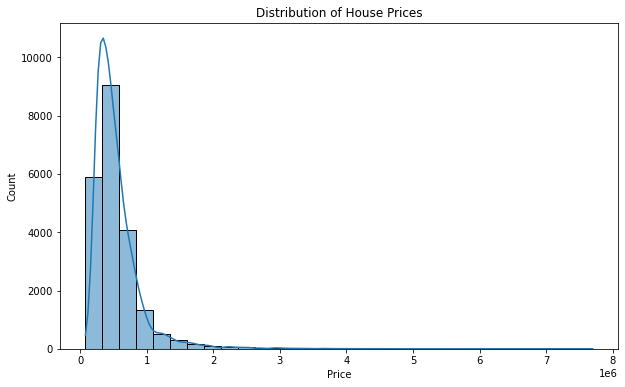

In [11]:
# Data Exploration
# Exploring the data by plotting some graphs to visualize the distribution of features.
# Using seaborn to create a histogram of the 'price' column.
plt.figure(figsize=(10, 6))
sns.histplot(house_data_df['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

## Price Distribution without Outliers

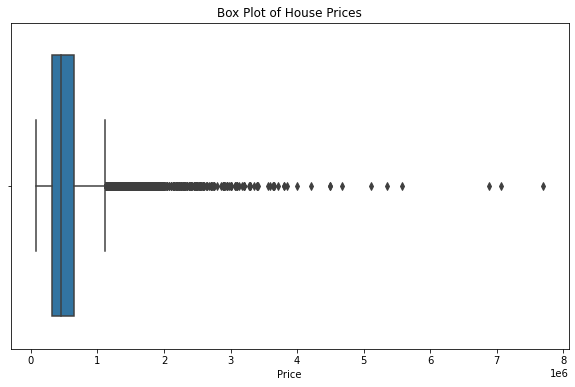

In [12]:
# Creating a box plot to identify outliers in the 'price' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=house_data_df['price'])
plt.title('Box Plot of House Prices')
plt.xlabel('Price')
plt.show()

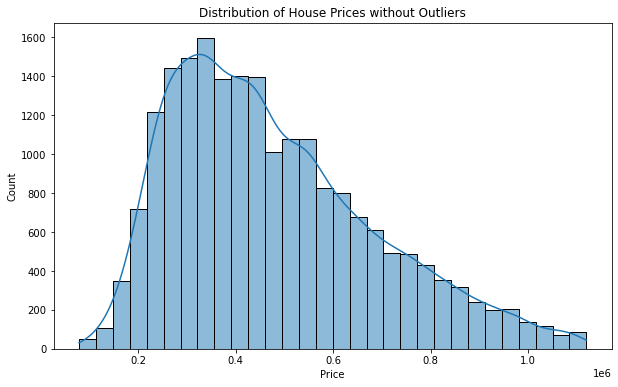

In [13]:
# Calculating the Interquartile Range (IQR) to identify outliers
Q1 = house_data_df['price'].quantile(0.25)
Q3 = house_data_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Defining the upper and lower bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to exclude outliers
filtered_house_data = house_data_df[(house_data_df['price'] >= lower_bound) & (house_data_df['price'] <= upper_bound)]

# Creating a histogram of house prices without outliers
plt.figure(figsize=(10, 6))
sns.histplot(filtered_house_data['price'], bins=30, kde=True)
plt.title('Distribution of House Prices without Outliers')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


In [14]:
print(filtered_house_data.shape)
print(house_data_df.shape)

(20381, 21)
(21534, 21)


## What is the relationship between sqft_living of a house and its price?

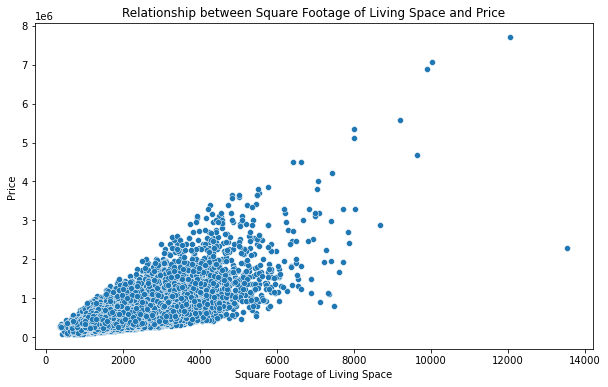

In [15]:
# Exploring the relationships between variables using scatter plots or pair plots.
# Checking the relationship between 'sqft_living' and 'price'.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqft_living', y='price', data=house_data_df)
plt.title('Relationship between Square Footage of Living Space and Price')
plt.xlabel('Square Footage of Living Space')
plt.ylabel('Price')
plt.show()

## How does the number of bathrooms affect the price of a house?

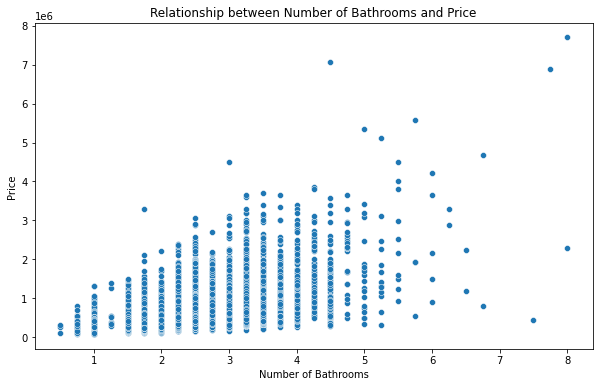

In [16]:
# Checking the relationship between 'bathrooms' and 'price'.
# Creating a scatterplot to visualize the relationship between 'bathrooms' and 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bathrooms', y='price', data=house_data_df)
plt.title('Relationship between Number of Bathrooms and Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.show()

## Are price and number of bedrooms correlated?

In [17]:
# Data Analysis
# Performing various data analyses and calculations to gain insights into the dataset. 
# Calculating the average price per bedroom.
average_price_per_bedroom = house_data_df.groupby('bedrooms')['price'].mean()
print(average_price_per_bedroom)

bedrooms
1     3.182395e+05
2     4.014601e+05
3     4.663525e+05
4     6.353843e+05
5     7.865267e+05
6     8.104932e+05
7     9.514478e+05
8     1.105077e+06
9     8.939998e+05
10    8.200000e+05
11    5.200000e+05
33    6.400000e+05
Name: price, dtype: float64


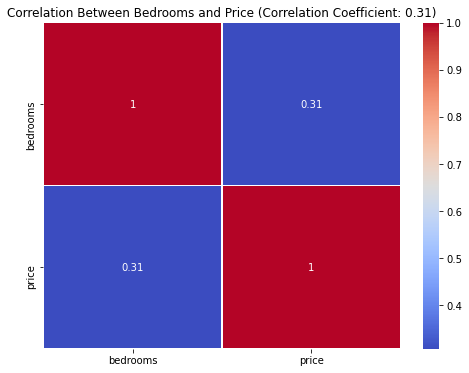

In [18]:
# Calculating the average price per bedroom.
# Calculating the Pearson correlation coefficient between 'bedrooms' and 'price'
correlation = house_data_df['bedrooms'].corr(house_data_df['price'])

# Creating a correlation heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(data=house_data_df[['bedrooms', 'price']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Correlation Between Bedrooms and Price (Correlation Coefficient: {correlation:.2f})')
plt.show()


## What is the relationship between the year a house was built and its price?

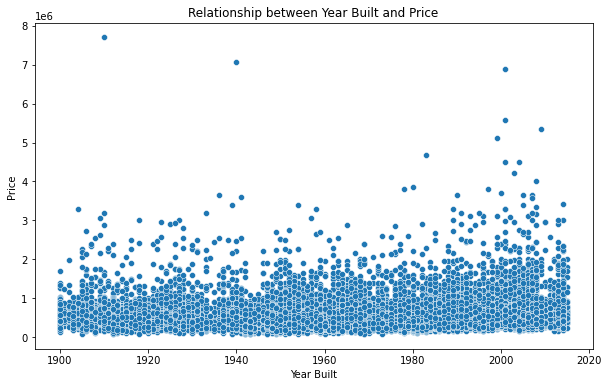

In [19]:
# Creating a scatterplot to visualize the relationship between 'yr_built' and 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='yr_built', y='price', data=house_data_df)
plt.title('Relationship between Year Built and Price')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.show()

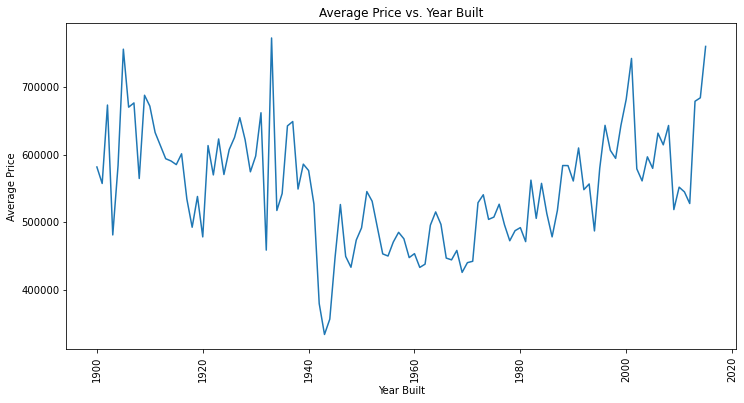

In [20]:
# Grouping the data by 'yr_built' and calculating the average price for each year
average_price_by_year = house_data_df.groupby('yr_built')['price'].mean().reset_index()

# Creating a line plot to visualize the relationship between 'yr_built' and 'price'
plt.figure(figsize=(12, 6))
sns.lineplot(x='yr_built', y='price', data=average_price_by_year)
plt.title('Average Price vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()


## How does the number of floors affect the price of a house?

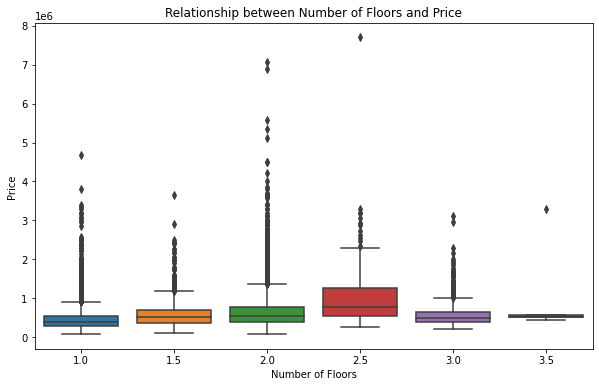

In [21]:
# Creating a boxplot to visualize the relationship between 'floors' and 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='floors', y='price', data=house_data_df)
plt.title('Relationship between Number of Floors and Price')
plt.xlabel('Number of Floors')
plt.ylabel('Price')
plt.show()

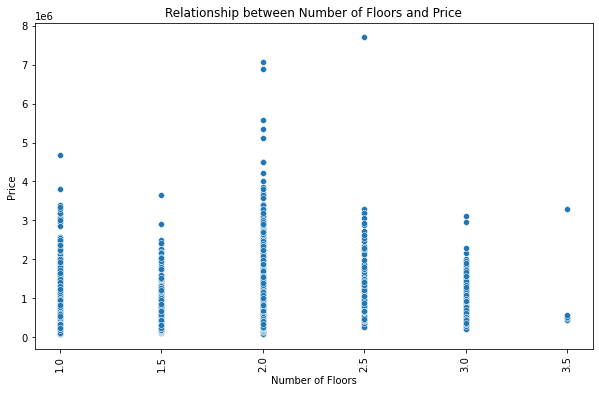

In [22]:
# Creating a scatter plot to visualize the relationship between 'floors' and 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floors', y='price', data=house_data_df)
plt.title('Relationship between Number of Floors and Price')
plt.xlabel('Number of Floors')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()